In [1]:
%matplotlib inline
import gzip
import shutil
from struct import unpack # 将字符串解包为变量，可以解析定长数据
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [3]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>5.2f}'

In [4]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

In [13]:
HTTPS_URL = 'https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/'
SOURCE_FILE = '07302019.NASDAQ_ITCH50.gz'

In [14]:
def download_file(url):
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()
    else:
        print('Directory exists')

    filename = data_path / url.split('/')[-1]
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)
    else:
        print('File exists')

    unzipped = data_path / (filename.stem + '.bin')
    if not unzipped.exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else:
        print('File already unpacked')
    return unzipped

In [15]:
file_name = download_file(urljoin(HTTPS_URL, SOURCE_FILE))
date = file_name.name.split('.')[0]

Directory exists
File exists
Unzipping to data/07302019.NASDAQ_ITCH50.bin


In [16]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

In [17]:
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

In [18]:
formats = {
    ('integer', 2): 'H',  # int of length 2 => format string 'H'
    ('integer', 4): 'I',
    ('integer', 6): '6s',  # int of length 6 => parse as string, convert later
    ('integer', 8): 'Q',
    ('alpha',   1): 's',
    ('alpha',   2): '2s',
    ('alpha',   4): '4s',
    ('alpha',   8): '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

In [21]:
message_data = (pd.read_excel('message_types.xlsx',
                              sheet_name='messages')
                .sort_values('id')
                .drop('id', axis=1))

In [22]:
message_data

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below
...,...,...,...,...,...
168,Far Price,36,4,Price (4),A hypothetical auction-clearing price for cros...
169,Near Price,40,4,Price (4),A hypothetical auction-clearing price for cros...
170,Current Reference Price,44,4,Price (4),The price at which the NOII shares are being c...
171,Cross Type,48,1,Alpha,The type of Nasdaq cross for which the NOII me...


# Data cleaning

In [23]:
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    print(df.value)
    df.value = df.value.str.strip()
    df.name = (df.name
               .str.strip() # remove whitespace
               .str.lower()
               .str.replace(' ', '_')
               .str.replace('-', '_')
               .str.replace('/', '_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

In [24]:
message_types = clean_message_types(message_data)
print(message_types)

0               S
1        Integer 
2        Integer 
3        Integer 
4          Alpha 
          ...    
168    Price (4) 
169    Price (4) 
170    Price (4) 
171        Alpha 
172        Alpha 
Name: value, Length: 173, dtype: object
                          name  offset  length      value  \
0                 message_type       0       1          S   
1                 stock_locate       1       2    Integer   
2              tracking_number       3       2    Integer   
3                    timestamp       5       6    Integer   
4                   event_code      11       1      Alpha   
..                         ...     ...     ...        ...   
168                  far_price      36       4  Price (4)   
169                 near_price      40       4  Price (4)   
170    current_reference_price      44       4  Price (4)   
171                 cross_type      48       1      Alpha   
172  price_variation_indicator      49       1      Alpha   

                             

In [25]:
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
# message_labels.to_csv('message_labels.csv', index=False)
message_labels.head()

/var/folders/ty/n6grjv393wl09m5d123kw_lh0000gn/T/ipykernel_12028/140752064.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  message_labels.name = (message_labels.name


,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


In [26]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name != 'message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))
message_types.info()
print(message_types)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB
                          name  offset  length    value  \
1                 stock_locate       1       2  integer   
2              tracking_number       3       2  integer   
3                    timestamp       5       6  integer   
4                   event_code      11       1    alpha   
6                 stock_locate       1       2  integer   
..                         ...     ...     ...      ...   
168                  far_price      36       4  price_4   
169                 near_price      40

/var/folders/ty/n6grjv393wl09m5d123kw_lh0000gn/T/ipykernel_12028/2518907417.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  message_types.value = (message_types.value
/var/folders/ty/n6grjv393wl09m5d123kw_lh0000gn/T/ipykernel_12028/2518907417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  message_types.value = (message_types.value


In [27]:
message_types.head()

,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


In [28]:
message_types.to_csv('message_types.csv', index=False)

In [29]:
message_types = pd.read_csv('message_types.csv')

In [30]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                            .apply(tuple, axis=1).map(formats))

In [31]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

In [32]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())
print(message_fields)

{'A': <class '__main__.A'>, 'B': <class '__main__.B'>, 'C': <class '__main__.C'>, 'D': <class '__main__.D'>, 'E': <class '__main__.E'>, 'F': <class '__main__.F'>, 'H': <class '__main__.H'>, 'I': <class '__main__.I'>, 'J': <class '__main__.J'>, 'K': <class '__main__.K'>, 'L': <class '__main__.L'>, 'P': <class '__main__.P'>, 'Q': <class '__main__.Q'>, 'R': <class '__main__.R'>, 'S': <class '__main__.S'>, 'U': <class '__main__.U'>, 'V': <class '__main__.V'>, 'W': <class '__main__.W'>, 'X': <class '__main__.X'>, 'Y': <class '__main__.Y'>, 'h': <class '__main__.h'>}


In [33]:
list(message_types.groupby('message_type'))

[('A',
                        name  offset  length    value  \
  72            stock_locate       1       2  integer   
  73         tracking_number       3       2  integer   
  74               timestamp       5       6  integer   
  75  order_reference_number      11       8  integer   
  76      buy_sell_indicator      19       1    alpha   
  77                  shares      20       4  integer   
  78                   stock      24       8    alpha   
  79                   price      32       4  price_4   
  
                                                  notes message_type formats  
  72               Locate code identifying the security            A       H  
  73                    Nasdaq internal tracking number            A       H  
  74                        Nanoseconds since midnight.            A      6s  
  75  The unique reference number assigned to the ne...            A       Q  
  76  The type of order being added. B = Buy Order. ...            A       s  
  7

In [34]:
alpha_fields.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, event_code to price_variation_indicator
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   offset        45 non-null     int64 
 1   length        45 non-null     int64 
 2   value         45 non-null     object
 3   notes         45 non-null     object
 4   message_type  45 non-null     object
 5   formats       45 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB


In [35]:
alpha_fields.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


In [36]:
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""
    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

In [37]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if m == 'R':
                dc.append('stock')
            try:
                store.append(mtype,
                         data,
                         format='t',
                         min_itemsize=s,
                         data_columns=dc)
            except Exception as e:
                print(e)
                print(mtype)
                print(data.info())
                print(pd.Series(list(m.keys())).value_counts())
                data.to_csv('data.csv', index=False)
                return 1
    return 0

In [38]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

In [40]:
start = time()
with file_name.open('rb') as data:
    while True:

        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)

        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')
        message_type_counter.update([message_type])

        # read & store message
        try:
            record = data.read(message_size - 1)
            message = message_fields[message_type]._make(unpack(fstring[message_type], record))
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)
            print(record)
            print(fstring[message_type])

        # deal with system events
        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break
        message_count += 1

        if message_count % 2.5e7 == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
            res = store_messages(messages)
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

print('Duration:', format_time(time() - start))


 Start of Messages
	03:02:50.64	  25,000,000

 Start of System Hours
	04:00:00.00	  25,237,169

 Start of Market Hours
	09:30:00.00	  35,411,212
	09:40:32.50	  50,000,000	00:00:40.07
	10:05:37.08	  75,000,000	00:04:03.69
	10:38:25.44	 100,000,000	00:05:59.69
	11:12:18.20	 125,000,000	00:07:56.60
	11:50:58.22	 150,000,000	00:09:51.54
	12:34:58.35	 175,000,000	00:11:48.77
	13:24:50.05	 200,000,000	00:13:44.33
	14:10:49.96	 225,000,000	00:15:42.76
	14:58:39.35	 250,000,000	00:17:38.94
	15:38:07.13	 275,000,000	00:19:34.24
	15:59:14.20	 300,000,000	00:21:34.18

 End of Market Hours
	16:00:00.00	 303,801,008

 End of System Hours
	20:00:00.00	 307,189,614

 End of Messages
	20:05:00.00	 307,229,683
Duration: 00:23:32.48


In [33]:
# 获取Message Type和Trade数据并降序排列
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
counter

,Message Type,# Trades
A,add_order_no_mpid_attribution,124164371
D,order_delete,119999061
U,order_replace,21253951
E,order_executed,7582422
I,noii,3723793
X,order_cancel,2358032
P,trade,1461010
F,add_order_mpid_attribution,1296379
L,market_participant_position,210706
C,order_executed_with_price,135573


In [34]:
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)

<ipython-input-35-2dd5fc7384bf>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)


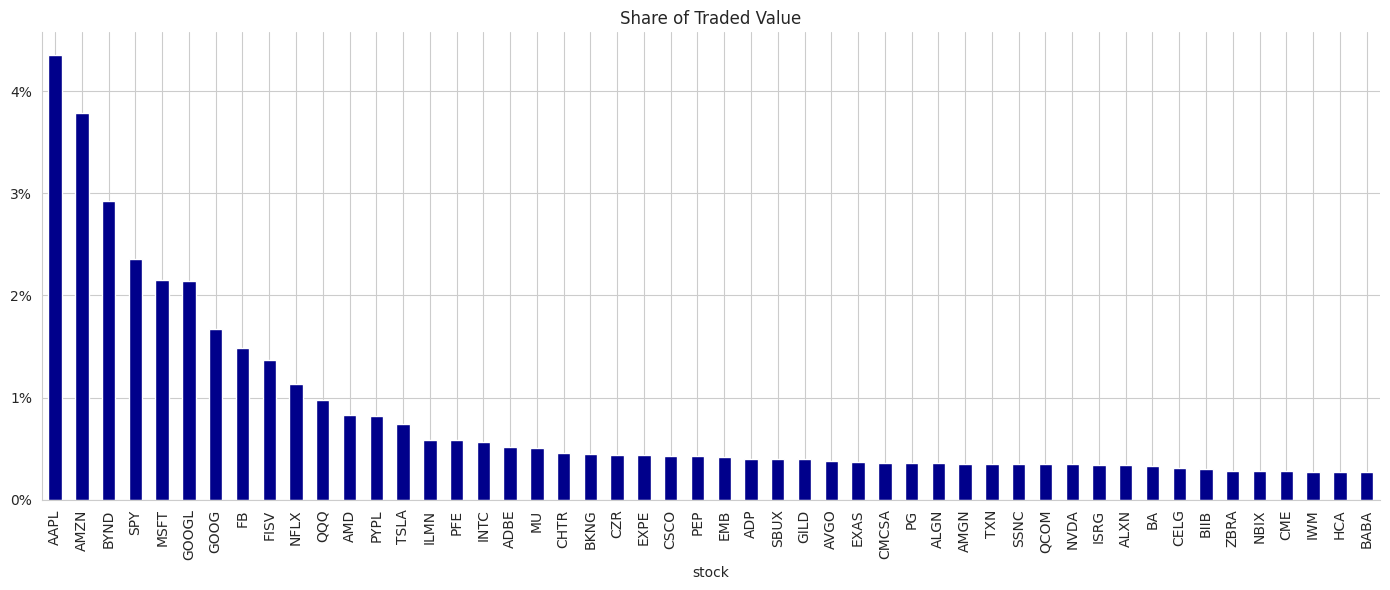

In [35]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()

In [39]:
with file_name.open('rb') as data:
     message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)

     print(message_size)

     print(data.read(1).decode("ascii"))

12
S


In [43]:
with pd.HDFStore(itch_store) as store:
    print(store['R'])

      stock_locate  tracking_number                 timestamp   stock  \
0                1                0 0 days 03:07:20.690615180       A   
1                2                0 0 days 03:07:20.690740789      AA   
2                3                0 0 days 03:07:20.690786821    AAAU   
3                4                0 0 days 03:07:20.690840751    AABA   
4                5                0 0 days 03:07:20.690884618     AAC   
...            ...              ...                       ...     ...   
8844          8845                0 0 days 03:07:20.925383765  ZXYZ.A   
8845          8846                0 0 days 03:07:20.925418549   ZXZZT   
8846          8847                0 0 days 03:07:20.925445584    ZYME   
8847          8848                0 0 days 03:07:20.925470514    ZYNE   
8848          8849                0 0 days 03:07:20.925495553    ZYXI   

     market_category financial_status_indicator  round_lot_size  \
0                  N                                    

#2

In [5]:
stock = 'AAPL'
order_dict = {-1: 'sell', 1: 'buy'}

In [6]:
date = '10302019'

In [ ]:
message_labels

,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position
46,V,market_wide_circuit_breaker_decline_level
53,W,market-wide_circuit_breaker_status
58,K,ipo_quoting_period_update
66,J,luld_auction_collar
75,h,operational_halt


In [10]:
def get_messages(date, stock=stock):
    data = {}
    with pd.HDFStore(itch_store) as store:
        stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
        target = 'stock_locate = stock_locate'

        # trading message types
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
        for m in messages:
            data[m] = store.select(m, where=target).drop('stock_locate', axis=1).assign(type=m)
    
    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    # A	add_order_no_mpid_attribution
    # F	add_order_mpid_attribution
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]
    
    for m in messages[2:-3]: # 'E', 'C', 'X', 'D'
        data[m] = data[m].merge(orders, how='left')
    
    # U	order_replace
    data['U'] = data['U'].merge(orders, how='left',
                               right_on='order_reference_number',
                               left_on='original_order_reference_number',
                               suffixes=['', '_replaced'])
    # Q	cross_trade
    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    # X order_cancel
    data['X']['shares'] = data['X'].cancelled_shares
    data['X'] = data['X'].dropna(subset=['price'])

    mdata = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
    mdata['date'] = pd.to_datetime(date, format='%m%d%Y')
    mdata.timestamp = mdata['date'].add(mdata.timestamp)
    mdata = mdata[mdata.printable != 0]

    drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
                    'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
                    'printable', 'date', 'cancelled_shares']
    return mdata.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)


In [11]:
messages = get_messages(date=date)
messages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474217 entries, 0 to 1474216
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   timestamp           1474217 non-null  datetime64[ns]
 1   buy_sell_indicator  1411386 non-null  float64       
 2   shares              1464943 non-null  float64       
 3   price               1464943 non-null  float64       
 4   type                1474217 non-null  object        
 5   executed_shares     73508 non-null    float64       
 6   execution_price     749 non-null      float64       
 7   shares_replaced     9464 non-null     float64       
 8   price_replaced      9464 non-null     float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 101.2+ MB


In [12]:
with pd.HDFStore(order_book_store) as store:
    key = f'{stock}/messages'
    store.put(key, messages)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/buy                 frame_table  (typ->appendable,nrows->52761448,ncols->2,indexers->[index],dc->[])
/AAPL/messages            frame        (shape->[1474217,9])                                               
/AAPL/sell                frame_table  (typ->appendable,nrows->60697866,ncols->2,indexers->[index],dc->[])
/AAPL/trades              frame        (shape->[89257,3])                                                 


In [13]:
# E	order_executed
# C	order_executed_with_price
# P	trade
# Q	cross_trade
def get_trades(m):
    """Combine C, E, P and Q messages into trading records"""
    trade_dict = {'executed_shares': 'shares', 'execution_price': 'price'}
    cols = ['timestamp', 'executed_shares']
    trades = pd.concat([m.loc[m.type == 'E', cols + ['price']].rename(columns=trade_dict),
                        m.loc[m.type == 'C', cols + ['execution_price']].rename(columns=trade_dict),
                        m.loc[m.type == 'P', ['timestamp', 'price', 'shares']],
                        m.loc[m.type == 'Q', ['timestamp', 'price', 'shares']].assign(cross=1),
                        ], sort=False).dropna(subset=['price']).fillna(0)
    return trades.set_index('timestamp').sort_index().astype(int)

In [14]:
trades = get_trades(messages)
print(trades.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89257 entries, 2019-10-30 04:03:22.436281050 to 2019-10-30 19:59:40.351922148
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   shares  89257 non-null  int64
 1   price   89257 non-null  int64
 2   cross   89257 non-null  int64
dtypes: int64(3)
memory usage: 2.7 MB
None


In [15]:
with pd.HDFStore(order_book_store) as store:
    store.put(f'{stock}/trades', trades)

In [16]:
def add_orders(orders, buysell, nlevels):
    """Add orders up to desired depth given by nlevels;
        sell in ascending, buy in descending order 按升序出售，按降序买入
    """
    new_order = []
    items = sorted(orders.copy().items())
    if buysell == 1:
        items = reversed(items)  
    for i, (p, s) in enumerate(items, start=1):
        new_order.append((p, s))
        if i == nlevels:
            break
    return orders, new_order

In [17]:
def save_orders(orders, append=False):
    cols = ['price', 'shares']
    for buysell, book in orders.items():
        df = (pd.concat([pd.DataFrame(data=data,
                                     columns=cols)
                         .assign(timestamp=t) 
                         for t, data in book.items()]))
        key = f'{stock}/{order_dict[buysell]}'
        df.loc[:, ['price', 'shares']] = df.loc[:, ['price', 'shares']].astype(int)
        with pd.HDFStore(order_book_store) as store:
            if append:
                store.append(key, df.set_index('timestamp'), format='t')
            else:
                store.put(key, df.set_index('timestamp'))

In [18]:
order_book = {-1: {}, 1: {}}
# -1 sell 1 buy
current_orders = {-1: Counter(), 1: Counter()}
message_counter = Counter()
nlevels = 100

start = time()
for message in messages.itertuples():
    i = message[0]
    if i % 1e5 == 0 and i > 0:
        print(f'{i:,.0f}\t\t{format_time(time() - start)}')
        save_orders(order_book, append=True)
        order_book = {-1: {}, 1: {}}
        start = time()
    if np.isnan(message.buy_sell_indicator):
        continue
    message_counter.update(message.type)

    buysell = message.buy_sell_indicator
    price, shares = None, None

    if message.type in ['A', 'F', 'U']:
        price = int(message.price)
        shares = int(message.shares)

        current_orders[buysell].update({price: shares})
        current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
        order_book[buysell][message.timestamp] = new_order

    if message.type in ['E', 'C', 'X', 'D', 'U']:
        if message.type == 'U':
            if not np.isnan(message.shares_replaced):
                price = int(message.price_replaced)
                shares = -int(message.shares_replaced)
        else:
            if not np.isnan(message.price):
                price = int(message.price)
                shares = -int(message.shares)

        if price is not None:
            current_orders[buysell].update({price: shares})
            if current_orders[buysell][price] <= 0:
                current_orders[buysell].pop(price)
            current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
            order_book[buysell][message.timestamp] = new_order

100,000		00:00:10.81
200,000		00:00:23.13
300,000		00:00:24.19
400,000		00:00:26.34
500,000		00:00:26.43
600,000		00:00:26.94
700,000		00:00:28.07
800,000		00:00:27.81
900,000		00:00:27.63
1,000,000		00:00:28.10
1,100,000		00:00:28.90
1,200,000		00:00:30.02
1,300,000		00:00:32.14
1,400,000		00:00:30.02


In [19]:
message_counter = pd.Series(message_counter)
print(message_counter)

A    659462
D    648186
E     70685
P     17820
X      1873
F      3159
U      9464
C       737
dtype: int64


In [20]:
with pd.HDFStore(order_book_store) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/buy                 frame_table  (typ->appendable,nrows->105522896,ncols->2,indexers->[index],dc->[])
/AAPL/messages            frame        (shape->[1474217,9])                                                
/AAPL/sell                frame_table  (typ->appendable,nrows->121395732,ncols->2,indexers->[index],dc->[])
/AAPL/trades              frame        (shape->[89257,3])                                                  


In [21]:
with pd.HDFStore(order_book_store) as store:
    buy = store[f'{stock}/buy'].reset_index().drop_duplicates()
    sell = store[f'{stock}/sell'].reset_index().drop_duplicates()

In [22]:
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

In [23]:
percentiles = [.01, .02, .1, .25, .75, .9, .98, .99]
pd.concat([buy.price.describe(percentiles=percentiles).to_frame('buy'),
           sell.price.describe(percentiles=percentiles).to_frame('sell')], axis=1)

,buy,sell
count,1.055227e+08,1.213957e+08
mean,2.083083e+02,2.131359e+02
std,2.186705e+00,9.888825e+02
min,1.000000e-02,2.073200e+02
1%,2.067300e+02,2.073300e+02
2%,2.070700e+02,2.073400e+02
10%,2.074800e+02,2.074700e+02
25%,2.077700e+02,2.077100e+02
50%,2.082600e+02,2.080900e+02
75%,2.090100e+02,2.084300e+02


In [24]:
buy = buy[buy.price > buy.price.quantile(.01)]
sell = sell[sell.price < sell.price.quantile(.99)]

In [25]:
market_open='0930'
market_close = '1600'

/var/folders/ty/n6grjv393wl09m5d123kw_lh0000gn/T/ipykernel_14955/3252412174.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(buy[buy.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price,
/opt/anaconda3/envs/haxy/lib/python3.9/site-packages/seaborn/distributions.py:2464: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/anaconda3/envs/haxy/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/ty/n6grjv393wl09m5d123kw_lh0000gn/T/ipykernel_14955/3252412174.py:5: UserW

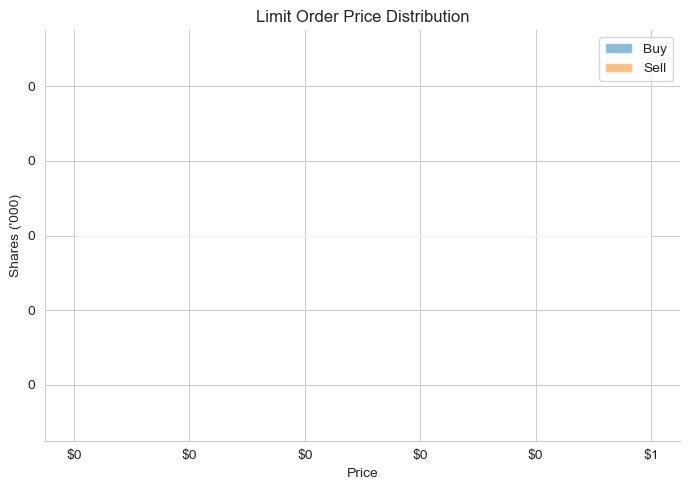

In [26]:
fig, ax = plt.subplots(figsize=(7,5))
hist_kws = {'linewidth': 1, 'alpha': .5}
sns.distplot(buy[buy.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price, 
             ax=ax, label='Buy', kde=False, hist_kws=hist_kws)
sns.distplot(sell[sell.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price, 
             ax=ax, label='Sell', kde=False, hist_kws=hist_kws)

ax.legend(fontsize=10)
ax.set_title('Limit Order Price Distribution')
ax.set_yticklabels([f'{int(y/1000):,}' for y in ax.get_yticks().tolist()])
ax.set_xticklabels([f'${int(x):,}' for x in ax.get_xticks().tolist()])
ax.set_xlabel('Price')
ax.set_ylabel('Shares (\'000)')
sns.despine()
fig.tight_layout()

In [27]:
utc_offset = timedelta(hours=4)
depth = 100

In [28]:
buy_per_min = (buy
               .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
               .shares
               .sum()
               .apply(np.log)
               .to_frame('shares')
               .reset_index('price')
               .between_time(market_open, market_close)
               .groupby(level='timestamp', as_index=False, group_keys=False)
               .apply(lambda x: x.nlargest(columns='price', n=depth))
               .reset_index())
buy_per_min.timestamp = buy_per_min.timestamp.add(utc_offset).astype(int)
buy_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78200 entries, 0 to 78199
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  78200 non-null  int64  
 1   price      78200 non-null  float64
 2   shares     78200 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.8 MB


In [29]:
sell_per_min = (sell
                .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
                .shares
                .sum()
                .apply(np.log)
                .to_frame('shares')
                .reset_index('price')
                .between_time(market_open, market_close)
                .groupby(level='timestamp', as_index=False, group_keys=False)
                .apply(lambda x: x.nsmallest(columns='price', n=depth))
                .reset_index())

sell_per_min.timestamp = sell_per_min.timestamp.add(utc_offset).astype(int)
sell_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78200 entries, 0 to 78199
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  78200 non-null  int64  
 1   price      78200 non-null  float64
 2   shares     78200 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.8 MB


In [30]:
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0].between_time(market_open, market_close)

trades_per_min = (trades
                  .resample('Min')
                  .agg({'price': 'mean', 'shares': 'sum'}))
trades_per_min.index = trades_per_min.index.to_series().add(utc_offset).astype(int)
trades_per_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 1572442200000000000 to 1572465540000000000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   390 non-null    float64
 1   shares  390 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 9.1 KB


/var/folders/ty/n6grjv393wl09m5d123kw_lh0000gn/T/ipykernel_14955/523295516.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)


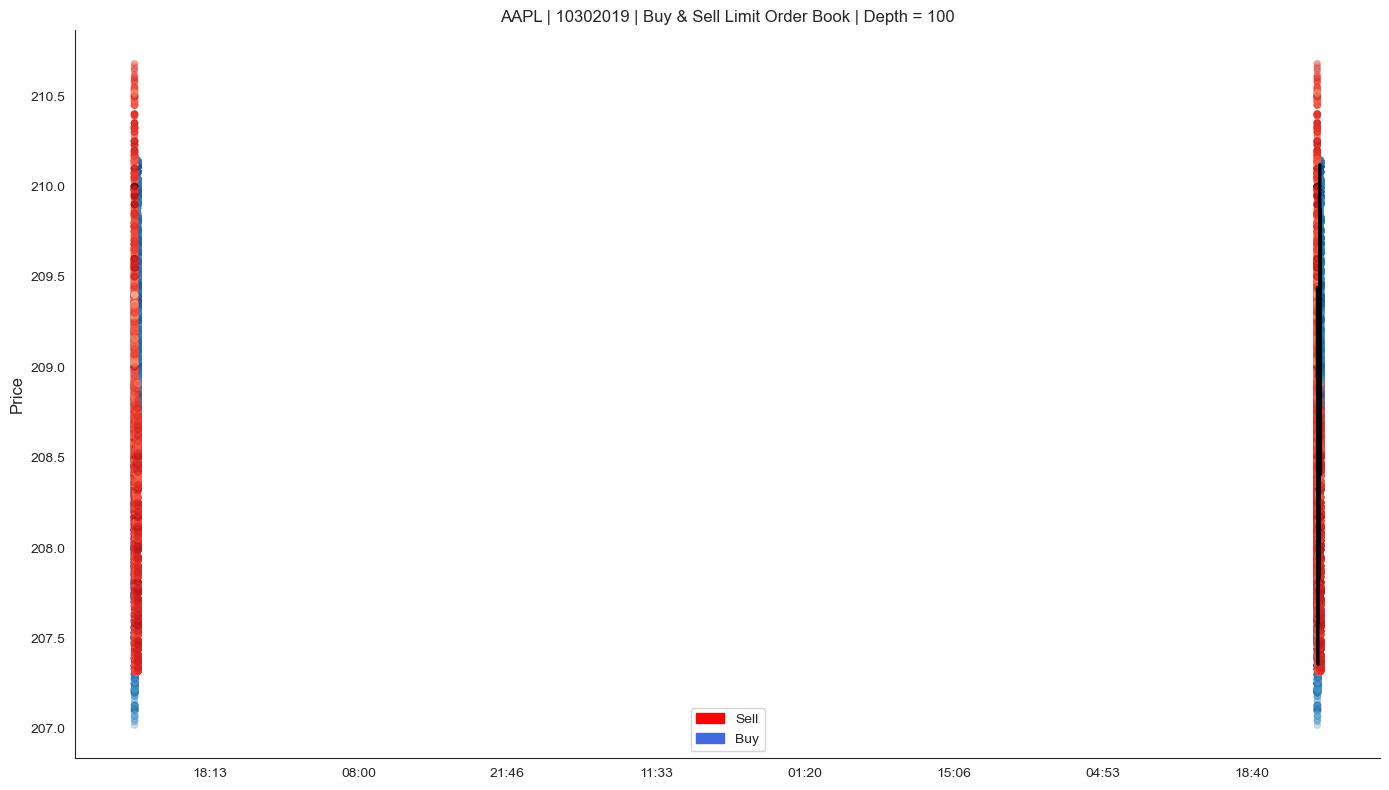

In [31]:
from datetime import datetime
import matplotlib.patches as mpatches
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14, 6))

buy_per_min.plot.scatter(x='timestamp',
                         y='price', 
                         c='shares', 
                         ax=ax, 
                         colormap='Blues', 
                         colorbar=False, 
                         alpha=.25)

sell_per_min.plot.scatter(x='timestamp',
                          y='price', 
                          c='shares', 
                          ax=ax, 
                          colormap='Reds', 
                          colorbar=False, 
                          alpha=.25)

title = f'AAPL | {date} | Buy & Sell Limit Order Book | Depth = {depth}'
trades_per_min.price.plot(figsize=(14, 8), 
                          c='k', 
                          ax=ax, 
                          lw=2, 
                          title=title)

xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

ax.set_xlabel('')
ax.set_ylabel('Price', fontsize=12)

red_patch = mpatches.Patch(color='red', label='Sell')
blue_patch = mpatches.Patch(color='royalblue', label='Buy')

plt.legend(handles=[red_patch, blue_patch])
sns.despine()
fig.tight_layout()